In [1]:
import matplotlib.pyplot as plt
import uproot
import numpy as np
import pandas as pd

from pathlib import Path
from sklearn.model_selection import train_test_split

from datetime import datetime
import sys

In [2]:
nfs_path = "/nfs/dust/belle2/user/axelheim/MC_studies/Dstlnu_Bt_generic/"

data_subdir = "Dstlnu_Hc_corr_BsigX_separation_dataRun1/"   
root_subdir = "axheim_data2_MC14_100kEvts/"   

root_path = nfs_path + "createBranchSeparatorData/" + root_subdir

## load dataframe 

In [3]:
df_FSPs = pd.read_csv(root_path + "df_FSPs_preProcessed.csv")
event_Bs = pd.read_csv(root_path + "event_Bs.csv")

## add labels to FSPs

In [4]:
def labels(s):
    label = 0
    event_iter = s['__event__']
    
    B_tag_uniqID = event_Bs[event_Bs.__event__ == event_iter].iloc[0]['B_tag_ID']
    B_sig_uniqID = event_Bs[event_Bs.__event__ == event_iter].iloc[0]['B_sig_ID']
    if s["B_ID"] == B_tag_uniqID:
        label = 1 # particle belongs to X (MC truth)
    elif s["B_ID"] == B_sig_uniqID:
        label = 2 # particle belongs to Bsig (MC truth)
    elif s["B_ID"] == 0:
        label = 0 # background  
        
    return label
df_FSPs['label'] = df_FSPs.apply(labels, axis=1)

In [14]:
mask = df_FSPs.Hc == 1
column_name = 'label'
df_FSPs.loc[mask, column_name] = 3

In [15]:
#save with labels

df_FSPs.to_csv(root_path + "df_FSPs_wLabels_stored.csv")
event_Bs.to_csv(root_path + "event_Bs_stored.csv")

## load dataframe with labels

In [2]:
df_FSPs = pd.read_csv(root_path + "df_FSPs_wLabels_stored.csv")
event_Bs = pd.read_csv(root_path + "event_Bs_stored.csv")

NameError: name 'root_path' is not defined

## print category combinations

In [4]:
vars_categories = ["label"]

categories = pd.DataFrame({'count' : df_FSPs.groupby( vars_categories ).size(),
                          'rel. freq.' : round((df_FSPs.groupby(vars_categories).size()/df_FSPs.shape[0]) * 100 , 2)}).reset_index()
categories

,label,count,rel. freq.
0,0,2335248,32.32
1,1,2145306,29.69
2,2,1927482,26.68
3,3,816476,11.30


In [5]:
vars_categories = ["label","basf2_X","basf2_Bsig","Hc"]

categories = pd.DataFrame({'count' : df_FSPs.groupby( vars_categories ).size(),
                          'rel. freq.' : round((df_FSPs.groupby(vars_categories).size()/df_FSPs.shape[0]) * 100 , 2)}).reset_index()
categories

,label,basf2_X,basf2_Bsig,Hc,count,rel. freq.
0,0,0.0,0.0,0,1789769,24.77
1,0,0.0,1.0,0,101117,1.40
2,0,1.0,0.0,0,444362,6.15
3,1,0.0,0.0,0,496882,6.88
4,1,0.0,1.0,0,613985,8.50
5,1,1.0,0.0,0,1034439,14.32
6,2,0.0,0.0,0,385864,5.34
7,2,0.0,1.0,0,739201,10.23
8,2,1.0,0.0,0,802417,11.11
9,3,0.0,0.0,1,816476,11.30


## check Hc assignment

In [6]:
groupsAllFSPs = pd.DataFrame({'count' : df_FSPs.groupby(["__event__","B_ID","Hc"]).size(),
                             'sum_p': df_FSPs.groupby(["__event__","B_ID","Hc"])["p"].sum()}).reset_index()

In [7]:
hasDuplicates = groupsAllFSPs[groupsAllFSPs["Hc"] == 1].sort_values("__event__").duplicated(subset="__event__", keep=False).value_counts() 
#/ groupsAllFSPs[groupsAllFSPs["Hc"] == 1].shape[0]
hasDuplicates

True     290691
False     69603
dtype: int64

In [8]:
num_events = groupsAllFSPs[groupsAllFSPs["Hc"] == 1]["__event__"].drop_duplicates(keep='first').shape[0]
num_events

210727

In [9]:
print("% of events with only one occurence of Hc regarding its ancestors:",round(hasDuplicates[0]/num_events * 100,2))

% of events with only one occurence of Hc regarding its ancestors: 33.03


## -> 33% of events belong to exactly one Hc ancestor -> many unclear Hc to B-tag's

## show sum_p distribution of unclear Hc assignments:

In [10]:
duplis = groupsAllFSPs[groupsAllFSPs["Hc"] == 1].duplicated(subset="__event__", keep=False)

# only events for which Hc mother assignment is unclear:
unclearHc=groupsAllFSPs[(groupsAllFSPs["Hc"] == 1) & (duplis == True)].sort_values("sum_p",ascending=False).sort_values("__event__")


unclearHc_winners = unclearHc.drop_duplicates(subset="__event__",keep='first')

In [21]:
groupsAllFSPs[groupsAllFSPs["Hc"] == 1].sort_values("__event__")[:15]

,__event__,B_ID,Hc,count,sum_p
3,14,83886082,1,4,1.963866
6,198,83886081,1,3,2.033263
8,198,83886082,1,1,0.432216
11,344,83886081,1,3,0.732831
13,344,83886082,1,1,0.879664
16,750,83886081,1,2,0.882200
18,750,83886082,1,1,1.021143
21,771,83886081,1,1,0.650442
23,771,83886082,1,3,1.106109
28,947,83886082,1,2,1.324788


In [11]:
unclearHc["__event__"].value_counts().value_counts()

2    132681
3      8443
Name: __event__, dtype: int64

In [12]:
ind = unclearHc[unclearHc.sort_values("sum_p").duplicated(subset="__event__")].index[:] # index of first appearance

unclearHc_loosers = unclearHc.drop(ind)
unclearHc_loosers[:10]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,__event__,B_ID,Hc,count,sum_p
8,198,83886082,1,1,0.432216
11,344,83886081,1,3,0.732831
16,750,83886081,1,2,0.882200
21,771,83886081,1,1,0.650442
28,947,83886082,1,2,1.324788
37,1120,83886082,1,1,0.225120
48,1746,83886081,1,1,0.693065
59,1895,83886082,1,1,0.611362
68,2322,83886082,1,2,0.423560
73,2397,83886082,1,2,0.545825


In [13]:
unclearHc[:10]

,__event__,B_ID,Hc,count,sum_p
6,198,83886081,1,3,2.033263
8,198,83886082,1,1,0.432216
13,344,83886082,1,1,0.879664
11,344,83886081,1,3,0.732831
18,750,83886082,1,1,1.021143
16,750,83886081,1,2,0.882200
23,771,83886082,1,3,1.106109
21,771,83886081,1,1,0.650442
28,947,83886082,1,2,1.324788
26,947,83886081,1,2,1.368286


In [14]:
unclearHc_winners[:10]

,__event__,B_ID,Hc,count,sum_p
6,198,83886081,1,3,2.033263
13,344,83886082,1,1,0.879664
18,750,83886082,1,1,1.021143
23,771,83886082,1,3,1.106109
28,947,83886082,1,2,1.324788
35,1120,83886081,1,2,1.064565
48,1746,83886081,1,1,0.693065
59,1895,83886082,1,1,0.611362
68,2322,83886082,1,2,0.423560
73,2397,83886082,1,2,0.545825


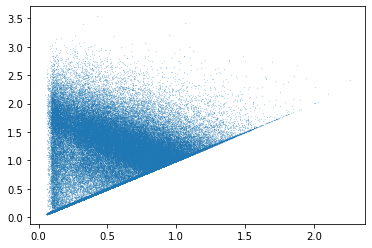

In [19]:
plt.scatter(unclearHc_loosers.sort_values("__event__")["sum_p"], unclearHc_winners.sort_values("__event__")["sum_p"],
           s=0.01)